In [172]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [173]:
# actual data
data_fetch_dates = ['0905', '0706', '0207']
actual_data = pd.concat([pd.merge(
    pd.read_csv(f'actualdata_trips_{date}.csv'), pd.read_csv(f'actualdata_stop_times_{date}.csv'), 
    how='left', left_on=['TripId'], right_on='TripId'
) for date in data_fetch_dates], axis=0)
actual_data['Month'] = [int(str(y)[4:6]) for y in actual_data['StartDate']]

# data cleaning: remove redundant column EntityId because it holds sim(EntityId, TripId) = 1
actual_data.drop('EntityId', axis=1, inplace=True)

actual_data.set_index(['TripId', 'StartDate'], inplace=True)
actual_data.head()

,,RouteId,StartTime,StopId,StopSequence,ArrivalDelay,ArrivalTime,DepartureDelay,DepartureTime,ScheduleRelationship,Month
TripId,StartDate,,,,,,,,,,
254163638,20230508,43975,19:44:00,9057862,NaN,NaN,NaN,0.0,NaN,Scheduled,5
282351984,20230509,43245,17:12:00,9013478,NaN,NaN,NaN,0.0,NaN,Scheduled,5
282385362,20230508,43195,20:03:00,9058008,5.0,-60.0,NaN,0.0,NaN,Scheduled,5
264505093,20230508,59935,19:12:00,9050640,11.0,30.0,NaN,30.0,NaN,Scheduled,5
282384857,20230509,43216,04:37:00,9049320,NaN,NaN,NaN,0.0,NaN,Scheduled,5


In [174]:
# target data
dir_target = 'C:\\Users\\nstan\\OneDrive\\Winfo\\SoSe_23\\Data Integration\\target_data_vbn_modified'
rnames = ['trips', 'stops', 'stop_times', 'agency', 'routes', 'transfers']
target_data = {rname: pd.read_csv(f'{dir_target}\\{rname}.csv', low_memory=False) for rname in rnames}

In [175]:
# perform joins on target data relations
# step 1: join routes and agency (= r1)
r1 = pd.merge(target_data['routes'], target_data['agency'], how='left', left_on=['agency_id'], right_on=['agency_id'])
r1.head(3)

,route_id,agency_id,route_short_name,route_type,agency_name
0,71026,1060,SEV24,1,S-Bahn Hamburg
1,71025,1060,SEV10,1,S-Bahn Hamburg
2,70978,1060,SEV21,2,S-Bahn Hamburg


In [176]:
# step 2: join r1 and trips (= r2)
#r2 = pd.merge(r1, target_data['trips'], how='left', left_on=['route_id'], right_on=['route_id'])
#r2.head(3)

In [177]:
# step 3: join r2 and stop_times (= r3)
#r3 = pd.merge(r2, target_data['stop_times'], how='left', left_on=['trip_id'], right_on=['trip_id'])
#r3.head(3)

In [178]:
# step 3: join r3 and stops (= r4)
#r4 = pd.merge(r3, target_data['stops'], how='left', left_on=['stop_id'], right_on=['stop_id'])
#r4.head(3)

In [179]:
# overall delay
arrival_delays = [x for x in actual_data['ArrivalDelay'] if not (pd.isna(x) or x == 0)]
departure_delays = [x for x in actual_data['DepartureDelay'] if not (pd.isna(x) or x == 0)]
ad = len(arrival_delays) / actual_data.shape[0] * 100
dd = len(departure_delays) / actual_data.shape[0] * 100
print('arrival delay in {x} % of rides'.format(x=round(ad, 2)))
print('departure delay in {x} % of rides'.format(x=round(dd, 2)))
print('arrival delay: {x}'.format(x=round(np.mean(arrival_delays), 2)))
print('departure delay: {x}'.format(x=round(np.mean(departure_delays), 2)))

arrival delay in 15.6 % of rides
departure delay in 17.99 % of rides
arrival delay: 110.68
departure delay: 134.61


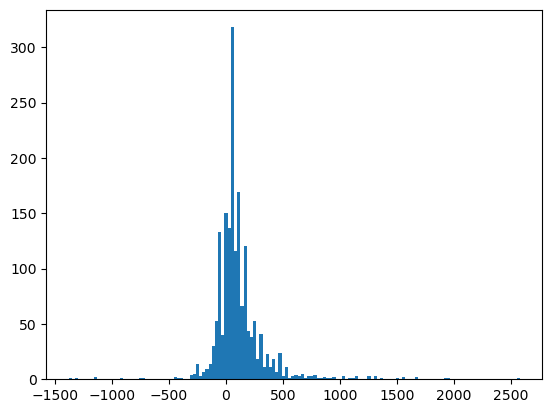

In [180]:
plt.hist(arrival_delays, bins='auto')
plt.show()

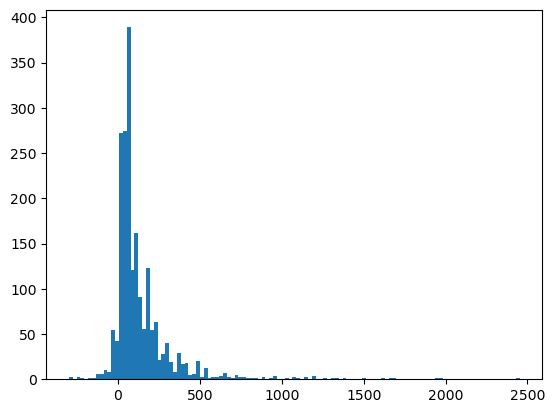

In [181]:
plt.hist(departure_delays, bins='auto')
plt.show()

In [182]:
actual_data[['Month', 'ArrivalDelay', 'DepartureDelay']].groupby('Month').count()

,ArrivalDelay,DepartureDelay
Month,,
5,773,2528
6,1451,5100
7,869,3577


In [183]:
actual_data[['Month', 'ArrivalDelay', 'DepartureDelay']].groupby('Month').mean()

,ArrivalDelay,DepartureDelay
Month,,
5,55.197930,20.106013
6,83.177808,34.854118
7,36.043728,12.414034


In [184]:
# step 3: join TARGET trips and stop_times
#r4 = pd.merge(target_data['stop_times'], target_data['trips'], how='left', left_on=['trip_id'], right_on=['trip_id'])
#r4.head(3)

In [185]:
# join actual and target data using RouteId
r = pd.merge(actual_data, r1, how='left', left_on=['RouteId'], right_on=['route_id'])

# biggest 5 agencies
agencies = ['DB Regio AG Nord', 'Bremer Straßenbahn AG',
            'üstra Hannoversche Verkehrsbetriebe AG',
            'RegioBus Hannover GmbH', 'NordWestBahn']

# delay according to different agencies
pd.concat([
    r.loc[r['agency_name'].isin(agencies)][['agency_name', 'ArrivalDelay']].where(~pd.isna(r['ArrivalDelay'])).where(
        r['ArrivalDelay'] != 0).groupby(['agency_name']).mean(),
    r.loc[r['agency_name'].isin(agencies)][['agency_name', 'DepartureDelay']].where(~pd.isna(r['DepartureDelay'])).where(
        r['DepartureDelay'] != 0).groupby(['agency_name']).mean()
], axis=1)#.loc[(r['agency_name'].value_counts() > 100).index[r['agency_name'].value_counts() > 200]].index

,ArrivalDelay,DepartureDelay
agency_name,,
Bremer Straßenbahn AG,41.569697,38.212838
DB Regio AG Nord,87.789474,164.835165
NordWestBahn,175.531915,417.500000
RegioBus Hannover GmbH,72.971429,139.707143
üstra Hannoversche Verkehrsbetriebe AG,127.000000,107.839572


In [186]:
# delay according to month and agencies
month_agency = pd.concat([
    r.loc[r['agency_name'].isin(agencies)][['Month', 'agency_name', 'ArrivalDelay']].where(~pd.isna(r['ArrivalDelay'])).where(
        r['ArrivalDelay'] != 0).groupby(['Month', 'agency_name']).mean(),
    r.loc[r['agency_name'].isin(agencies)][['Month', 'agency_name', 'DepartureDelay']].where(~pd.isna(r['DepartureDelay'])).where(
        r['DepartureDelay'] != 0).groupby(['Month', 'agency_name']).mean()
], axis=1)
month_agency

ArrivalDelay  DepartureDelay
Month agency_name                                                         
5.0   Bremer Straßenbahn AG                      10.772727       21.051724
      DB Regio AG Nord                           33.333333      100.800000
      NordWestBahn                              206.000000      592.500000
6.0   Bremer Straßenbahn AG                       8.956989       25.369565
      DB Regio AG Nord                          158.918919      236.842105
      NordWestBahn                              229.411765      378.000000
      RegioBus Hannover GmbH                     77.875000      146.378378
      üstra Hannoversche Verkehrsbetriebe AG    167.090909      117.255639
7.0   Bremer Straßenbahn AG                     115.780000      100.407407
      DB Regio AG Nord                           50.322581      124.285714
      NordWestBahn                               84.000000      250.000000
      RegioBus Hannover GmbH                     62.272727      114.172414
      üstra Hannoversche Verkehrsbetriebe AG     38.800000       84.648148

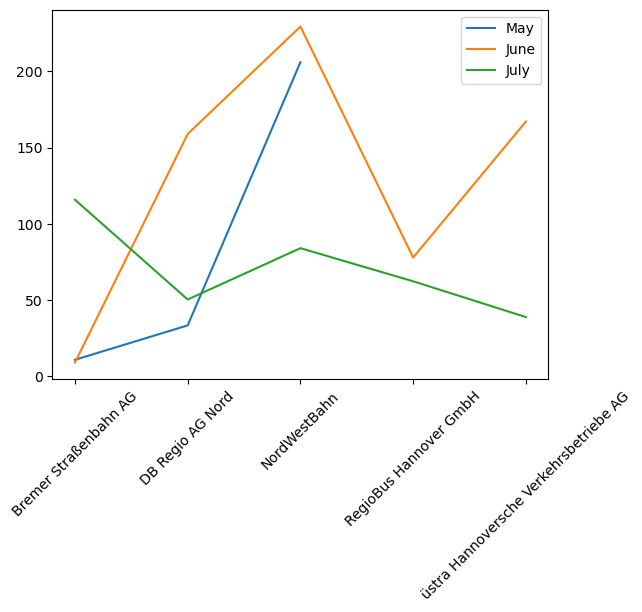

In [187]:
plt.plot(month_agency.loc[5, 'ArrivalDelay'], label='May')
plt.plot(month_agency.loc[6, 'ArrivalDelay'], label='June')
plt.plot(month_agency.loc[7, 'ArrivalDelay'], label='July')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [188]:
# delay according to agencies and month
month_agency_2 = pd.concat([
    r.loc[r['agency_name'].isin(agencies)][['Month', 'agency_name', 'ArrivalDelay']].where(~pd.isna(r['ArrivalDelay'])).where(
        r['ArrivalDelay'] != 0).groupby(['agency_name', 'Month']).mean(),
    r.loc[r['agency_name'].isin(agencies)][['Month', 'agency_name', 'DepartureDelay']].where(~pd.isna(r['DepartureDelay'])).where(
        r['DepartureDelay'] != 0).groupby(['agency_name', 'Month']).mean()
], axis=1)
month_agency_2

ArrivalDelay  DepartureDelay
agency_name                            Month                              
Bremer Straßenbahn AG                  5.0       10.772727       21.051724
                                       6.0        8.956989       25.369565
                                       7.0      115.780000      100.407407
DB Regio AG Nord                       5.0       33.333333      100.800000
                                       6.0      158.918919      236.842105
                                       7.0       50.322581      124.285714
NordWestBahn                           5.0      206.000000      592.500000
                                       6.0      229.411765      378.000000
                                       7.0       84.000000      250.000000
RegioBus Hannover GmbH                 6.0       77.875000      146.378378
                                       7.0       62.272727      114.172414
üstra Hannoversche Verkehrsbetriebe AG 6.0      167.090909      117.255639
                                       7.0       38.800000       84.648148

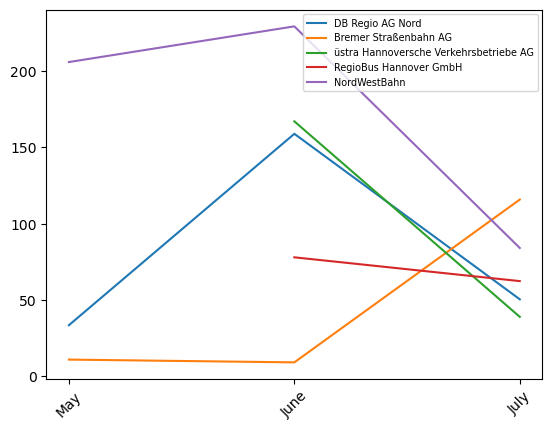

In [189]:
month_map = {5: 'May', 6: 'June', 7:'July'}
for agency in agencies:
    t = month_agency_2.loc[agency, 'ArrivalDelay']
    t = pd.Series(t.values, index=[month_map[x] for x in t.index])
    plt.plot(t, label=agency)
plt.xticks(rotation=45)
plt.legend(fontsize='x-small', loc='best')
plt.show()